In [1]:
##########
# INPUT  #
##########
datapath = '/home/ec2-user/SageMaker/mariano/datasets/multiculturalism/files/new_scores.csv'

##########
# OUTPUT #
##########
topics_csv = '/home/ec2-user/SageMaker/mariano/datasets/multiculturalism/top2vec/deep_learn_top2vec_topics.csv'

# this one is not used, when re runing the script top2vec gives different answer (not deterministic)
# topics_csv = '/home/ec2-user/SageMaker/mariano/datasets/multiculturalism/top2vec/deep_learn_top2vec_topics_with_rel.csv'


In [3]:
import pandas as pd
df = pd.read_csv(datapath)
df.shape


(8101, 6)

In [2]:
from top2vec import Top2Vec

Matplotlib is building the font cache; this may take a moment.


In [3]:
import sys
sys.path.append('/home/ec2-user/SageMaker/mariano/repositories/tdmstudio-high-recall-information-retrieval-system/')
from utils import tdmstudio

import pandas as pd

df = pd.read_csv(datapath)
df['text'] = list(map(lambda id_: tdmstudio.get_title_and_text(tdmstudio.get_filename(str(id_))), df['id']))
df.head()

,URL,relevant_or_suggested,confidence,id,new_score,title,text
0,https://proquest.com/docview/1151636504,rel,1.0,1151636504,1.0,Not just folklore--a tool for trade.,Not just folklore--a tool for trade.\n ...
1,https://proquest.com/docview/1151316407,rel,1.0,1151316407,1.0,Display Ad 41 -- No Title.,Display Ad 41 -- No Title.\n \n ...
2,https://proquest.com/docview/1366203438,rel,1.0,1366203438,1.0,Sounds and the city.,Sounds and the city.\n \n ...
3,https://proquest.com/docview/1126309571,rel,1.0,1126309571,1.0,Unfamiliar liberty delights Iranians.,Unfamiliar liberty delights Iranians.\n ...
4,https://proquest.com/docview/1125764078,rel,1.0,1125764078,1.0,Private-school debate grows.,Private-school debate grows.\n \n ...


In [ ]:
trained=False
if not trained:
    print('Training model')
    deep_model = Top2Vec(documents=list(df['text']), speed='deep-learn', workers=1)
    trained=True

2023-01-03 13:52:27,026 - top2vec - INFO - Pre-processing documents for training


Training model


2023-01-03 13:52:43,854 - top2vec - INFO - Creating joint document/word embedding


In [11]:
data = {'topic no.': [], 
        'size': [], 
        'relevant count': [], 
        'example': [], 
        'example(rel)':[], 
        'suggestions':[], 
        'relevants':[],
        'suggestions (by relevance)': [],
       }
topic_sizes, topic_nums = deep_model.get_topic_sizes()
topic_words, word_scores, topic_nums = deep_model.get_topics()
for word_ix,_ in enumerate(topic_words[0]):
    data[f'word_{word_ix:03}']=[]

df['top2vec']=deep_model.doc_top
df['doc_dist']=deep_model.doc_dist

for ix in range(len(topic_nums)):
    # Topic number & size 
    data['topic no.'].append(topic_nums[ix])
    data['size'].append(topic_sizes[ix])
    
    # auxdf
    auxdf=df[df['top2vec']==topic_nums[ix]]
    
    # Example highly relevant to topic
    data['example'].append('https://proquest.com/docview/'+str(auxdf.sort_values(by='doc_dist',ascending=False)['id'].iloc[0]))
    
    # Suggestions IDs (sorted by topic)
    suggestions_ids=auxdf[auxdf['relevant_or_suggested']=='sugg'].sort_values(by='doc_dist',ascending=False)['id']
    data['suggestions'].append(';'.join([str(elem) for elem in suggestions_ids]))
    
    # Suggestions IDs (by relevance)
    #NOT USED BECAUSE WE CANNOT RE RUN THIS SCRIPT, gives different topics 
    # and Serperi is already working with the other topics:
    
#     suggestions_ids=auxdf[auxdf['relevant_or_suggested']=='sugg'].sort_values(by='new_score',ascending=False)['id']
#     data['suggestions (by relevance)'].append(';'.join([str(elem) for elem in suggestions_ids]))
    
    # Labelled as relevant IDs
    relevant_ids=auxdf[auxdf['relevant_or_suggested']=='rel'].sort_values(by='doc_dist',ascending=False)['id']
    data['relevants'].append(';'.join([str(elem) for elem in relevant_ids]))
    
    
    # Filter auxdf to have only relevant (not suggestions)
    auxdf=auxdf[auxdf['relevant_or_suggested']=='rel']
    
    # Relevant example highly relevant to topic.
    if auxdf.shape[0]>0:
        data['example(rel)'].append('https://proquest.com/docview/'+str(auxdf.sort_values(by='doc_dist',ascending=False)['id'].iloc[0]))
    else:
        data['example(rel)'].append('')
        
    # No. of relevant in topic
    data['relevant count'].append(auxdf.shape[0])
    
    # Words in topic
    for word_ix,word in enumerate(topic_words[ix]):
        data[f'word_{word_ix:03}'].append(word)

output_df = pd.DataFrame(data)
output_df.to_csv(topics_csv)
output_df

,topic no.,size,relevant count,example,example(rel),suggestions,relevants,suggestions (by relevance),word_000,word_001,...,word_040,word_041,word_042,word_043,word_044,word_045,word_046,word_047,word_048,word_049
0,0,587,1,https://proquest.com/docview/1366203412,https://proquest.com/docview/2459966061,1366203412;1371240574;1400817691;1412658808;14...,2459966061,1513576280;1125427022;1368202964;1288538999;11...,architecture,architectural,...,concrete,developers,manhattan,windows,kpmb,gehry,alsop,interior,courtyard,calatrava
1,1,364,2,https://proquest.com/docview/1371142585,https://proquest.com/docview/1237728590,1371142585;1368277382;1434946157;1412211630;13...,1237728590;1147042690,1125021012;1142893966;1291536461;1444911324;13...,film,films,...,video,theatre,funny,writer,fiction,theatrical,story,footage,novels,tale
2,2,322,2,https://proquest.com/docview/1143563372,https://proquest.com/docview/1125764078,1143563372;2610222836;1291391997;1143707847;24...,1125764078;1125547053,1238681375;1412271450;1151314133;2459858043;11...,schools,catholic,...,protestant,secular,trustee,children,classrooms,caroline,public,stu,lic,secondary
3,3,286,3,https://proquest.com/docview/2273226070,https://proquest.com/docview/1143705076,2273226070;1366148402;1151562632;1125678812;11...,1143705076;1237268511;1146095326,1356704961;1444870337;1142915398;1411931838;13...,my,girl,...,immigrated,kids,hair,love,brother,teenage,hus,strangers,india,grandmother
4,4,268,1,https://proquest.com/docview/1151354973,https://proquest.com/docview/1400724651,1151354973;1147063763;1238510250;1238483526;12...,1400724651,1238508053;1242128883;1238546138;1811318237;11...,meech,accord,...,text,provinces,agreement,fundamental,consent,tutional,brian,recognizing,senators,wells
5,5,249,15,https://proquest.com/docview/1323537660,https://proquest.com/docview/1148596840,1323537660;1143960323;1145230513;1148423270;11...,1148596840;1143312937;1143664837;1145146066;11...,1237192311;1147616449;1237671607;1151127952;14...,bissoondath,finestone,...,identities,racists,letter,racial,ciety,fulford,origins,writer,ethnocultural,coyne
6,6,247,1,https://proquest.com/docview/1136310592,https://proquest.com/docview/1145627214,1136310592;1126318234;1136005083;1136115911;11...,1145627214,1444885137;1143820055;1143583429;1141200544;11...,referendum,sovereigntists,...,defeat,pendence,yes,voters,meech,pari,francophone,dion,jacques,landry
7,7,234,2,https://proquest.com/docview/1400807548,https://proquest.com/docview/1371108106,1400807548;1368272427;1238459153;1368130128;26...,1371108106;1411791122,1356699776;1369092752;1371168010;1444871552;11...,skilled,immigrants,...,shortages,compared,median,earning,unskilled,numbers,earned,rates,aver,bom
8,8,224,0,https://proquest.com/docview/1242157735,,1242157735;1240431435;1241705686;1241350040;12...,,1151435666;2459947867;1368886241;1240393512;12...,investment,manufacturing,...,asbestos,operations,billion,electric,dustrial,labor,enterprises,savings,aluminum,plants
9,9,220,1,https://proquest.com/docview/1151514955,https://proquest.com/docview/1151128247,1151514955;1142598863;1287457964;1369136301;12...,1151128247,2273291444;1434931842;1151103566;1239216435;11...,inuit,cree,...,reconciliation,oka,northwest,ab,kunuk,metis,chief,mohawk,eskimos,remote


# topics size distribution histogram

Text(0.5, 0, 'Topic Size')

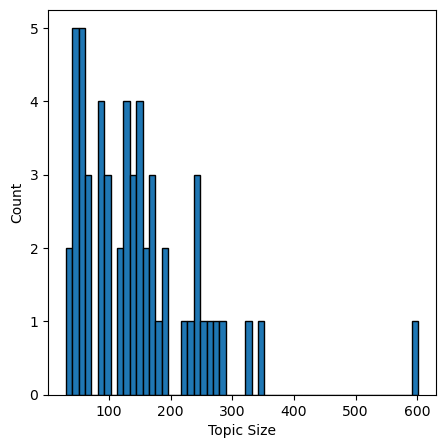

In [109]:
import matplotlib.pyplot as plt
topic_sizes, topic_nums = deep_model.get_topic_sizes()
fig,ax=plt.subplots(1,figsize=(5,5))
ax.hist(topic_sizes, bins=55,edgecolor='black')
ax.set_ylabel('Count')
ax.set_xlabel('Topic Size')

In [ ]:
# from utils import tdmstudio
# topics = {}
# topic_words, word_scores, topic_nums = model.get_topics()
# for topic in  sorted(set(df['top2vec'])):
#     topics[topic]={}
#     auxdf=df[df['top2vec']==topic]
#     topics[topic]['docs']=[str(id_) for id_ in auxdf.sort_values(by='doc_dist',ascending=False)['id']]
#     topics[topic]['words']=list(topic_words[topic])
#     topics[topic]['representative']=tdmstudio.get_title_and_text(tdmstudio.get_filename(topics[topic]['docs'][0]))
#     topics[topic]['vector']=model.topic_vectors[topic,:]
    
            
#     auxdf=auxdf[auxdf['relevant_or_suggested']=='rel']
#     topics[topic]['no_of_relevants']=auxdf.shape[0]
    

# topics[0]

In [4]:
# model = Top2Vec(documents=list(df['text']), speed='learn', workers=4)

2022-12-26 15:41:49,292 - top2vec - INFO - Pre-processing documents for training
2022-12-26 15:42:05,525 - top2vec - INFO - Creating joint document/word embedding
2022-12-26 15:59:20,517 - top2vec - INFO - Creating lower dimension embedding of documents
2022-12-26 15:59:31,147 - top2vec - INFO - Finding dense areas of documents
2022-12-26 15:59:31,440 - top2vec - INFO - Finding topics
